### Importations

In [1]:
import os
import numpy as np
import xarray as xr
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List, Tuple, TypeAlias
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
plt.rc('text', usetex=True)
plt.rcParams.update({
    'text.usetex': True,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

# Run forward *Tunax* for all the 1m simulations

In [ ]:
from tunax import Obs, SingleColumnModel
from tunax.closures import KepsParameters

timeframe_list = [6, 12, 18, 24, 36, 48, 72]
space_step_list = [0.75, 1, 2, 4]
forcing_list = ['free_convection', 'weak_wind_strong_cooling',
                'med_wind_med_cooling', 'strong_wind_weak_cooling', 'strong_wind',
                'strong_wind_no_rotation']
var_names = {
    'time': 't',
    'zr': 'zr',
    'zw': 'zw',
    't': 'T',
    's': 'S',
    'u': 'u',
    'v': 'v',
    'grav': 'gravitational_acceleration',
    'alpha': 'thermal_expansion',
    'beta': 'haline_contraction',
    'tflx_sfc': 'temperature_flux',
    # 'tflx_btm': 'dthetadz_deep',
    'fcor': 'Coriolis',
    'ustr_sfc': 'momentum_flux'
}


In [3]:

for forcing in forcing_list:
    for timeframe in timeframe_list[:1]:
        print(forcing, timeframe)
        space_step = space_step_list[1]
        filename = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
        filename_yaml = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')
        output_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        obs = Obs.from_files(filename, filename_yaml, var_names)
        traj_wagner = obs.trajectory

        # inversion du flux
        obs: Obs = eqx.tree_at(lambda t: t.case.tflx_sfc, obs, -obs.case.tflx_sfc)
        obs: Obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.case.ustr_sfc)

        time_frame = float(traj_wagner.time[-1]/3600)
        dt = 10.
        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
        init_state = traj_wagner.extract_state(0)
        model = SingleColumnModel(time_frame, dt, out_dt, init_state, obs.case, 'k-epsilon', output_path)

        keps_params = KepsParameters()

        model.compute_trajectory_with(keps_params)

free_convection 6


KeyError: "No variable named ''. Variables on the dataset include ['t', 'zw', 'zr', 'Ri', 'T', ..., 'ww', 'KdzT', 'mudzu', 'mudzv', 'mudzw']"

# Huge plots of Wagner

In [21]:

def plot(timeframe, space_step):
    sp: subplot_2D_type = plt.subplots(3, 6, sharey=True, figsize=(16, 12))
    fig, [axs_t, axs_uv, axs_pt] = sp

    for i_forcing in range(len(forcing_list)):
        forcing = forcing_list[i_forcing]
        wagner_path = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.nc')
        filename_yaml = os.path.join('k-epsilon_Wagner_LES', 'Wagner_LES', f'{timeframe}_hour_suite', f'{space_step}m', f'{forcing}_instantaneous_statistics.yaml')
        wagner_obs: Obs = Obs.from_files(wagner_path, filename_yaml, var_names)
        wagner_traj = wagner_obs.trajectory
        tunax_path = os.path.join('k-epsilon_Wagner_LES', 'tunax_scm_output', 'default_keps', f'{space_step}m_{timeframe}h_{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)

        axs_t[i_forcing].plot(wagner_traj.t[-1, :], wagner_traj.grid.zr, 'r')
        # axs_t[i_forcing].plot(tunax_ds.t[0, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'r')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'r--')
            # axs_uv[i_forcing].plot(tunax_ds.u[0, :], wagner_traj.grid.zr, 'g')
            # axs_uv[i_forcing].plot(tunax_ds.v[0, :], wagner_traj.grid.zr, 'g--')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].set_title(f'time = {timeframe}h')
    axs_uv[0].legend(loc='center')
    axs_uv[0].axis('off')

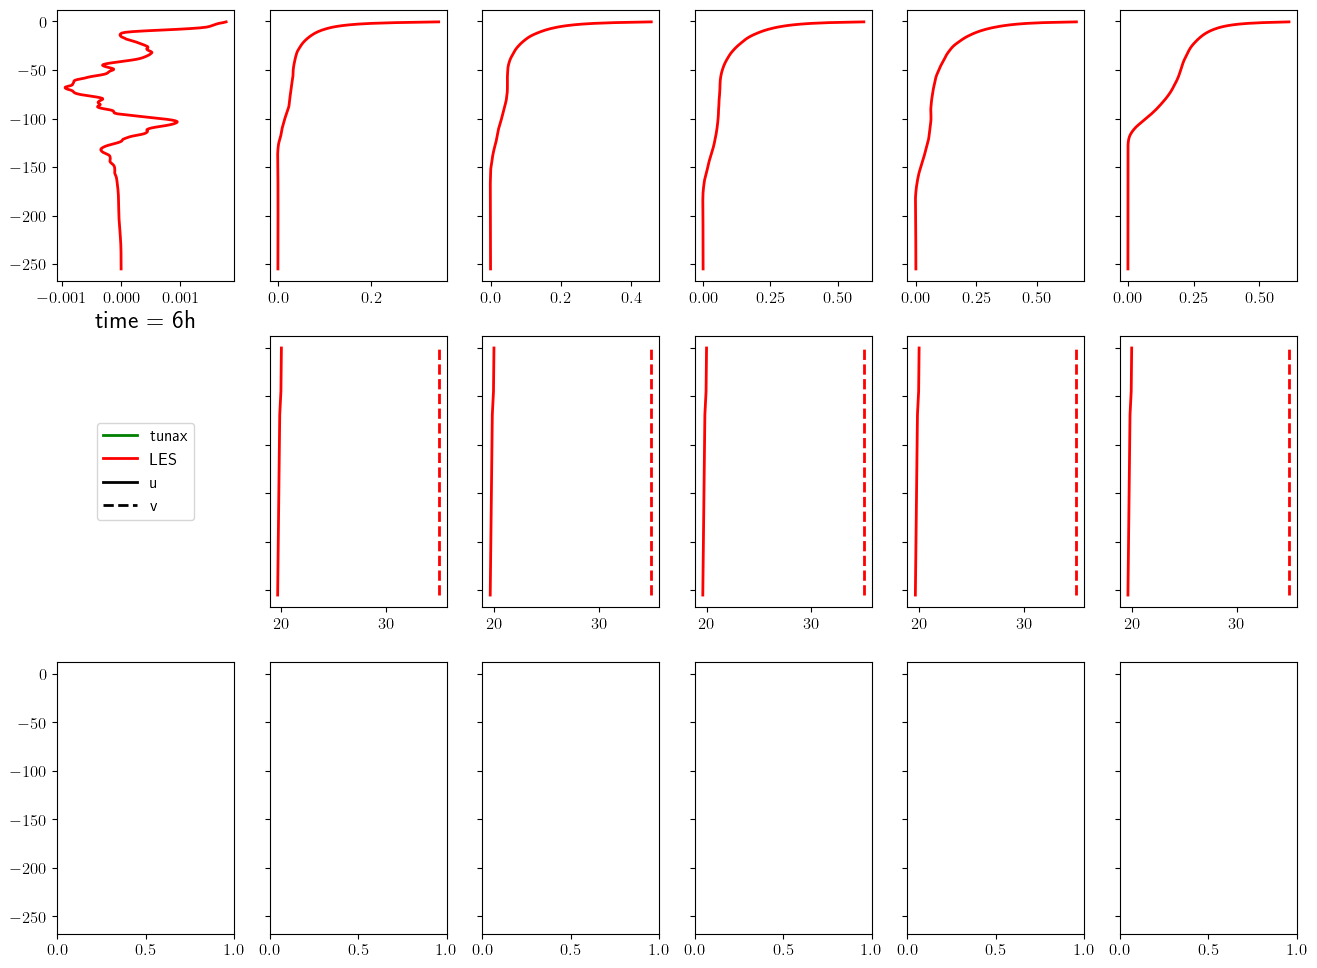

In [22]:
plot(6, 1)

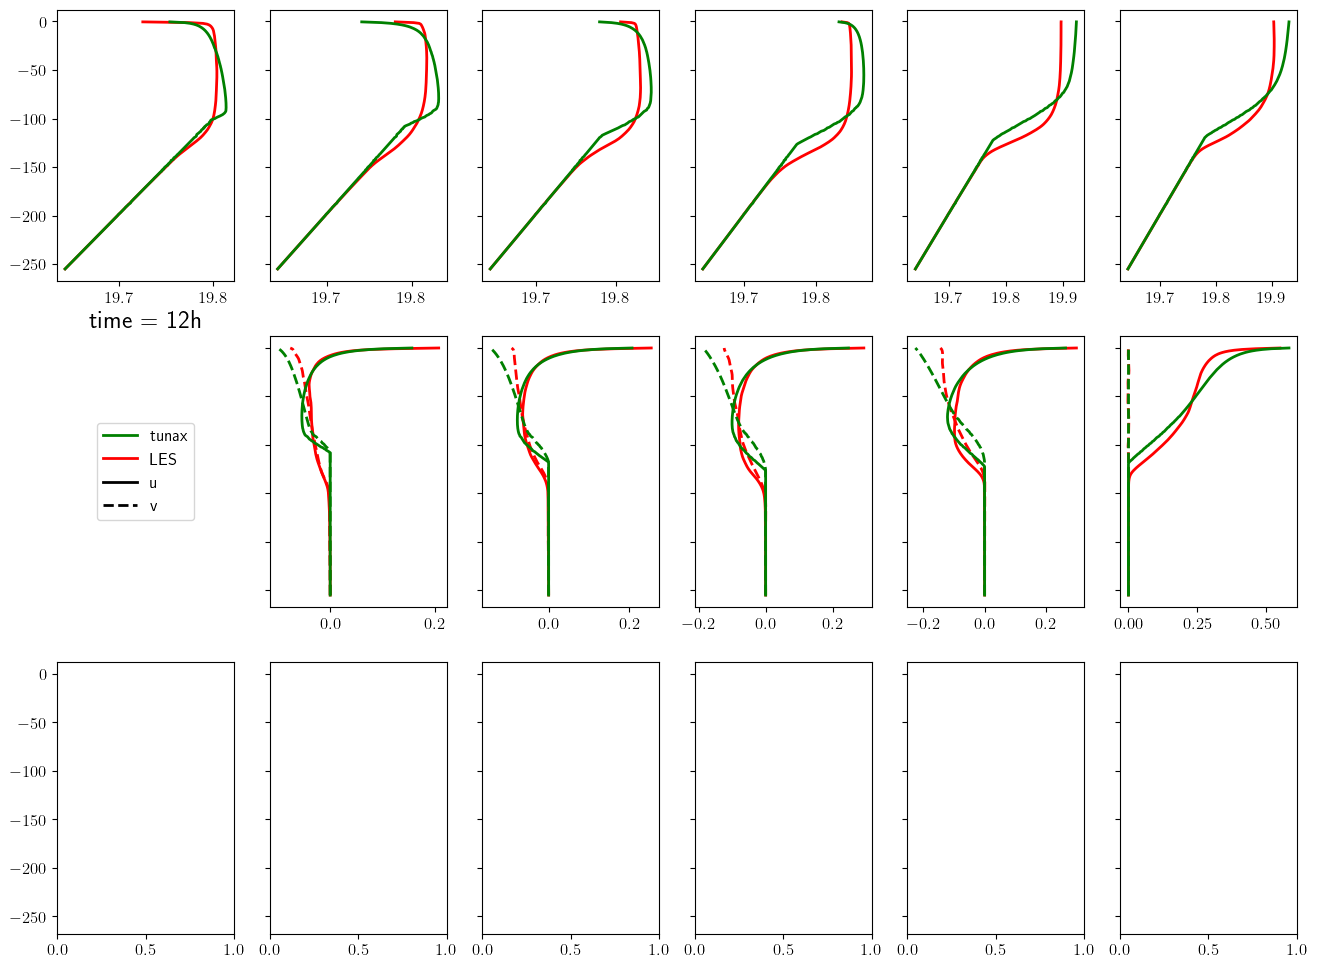

In [28]:
plot(12, 1)


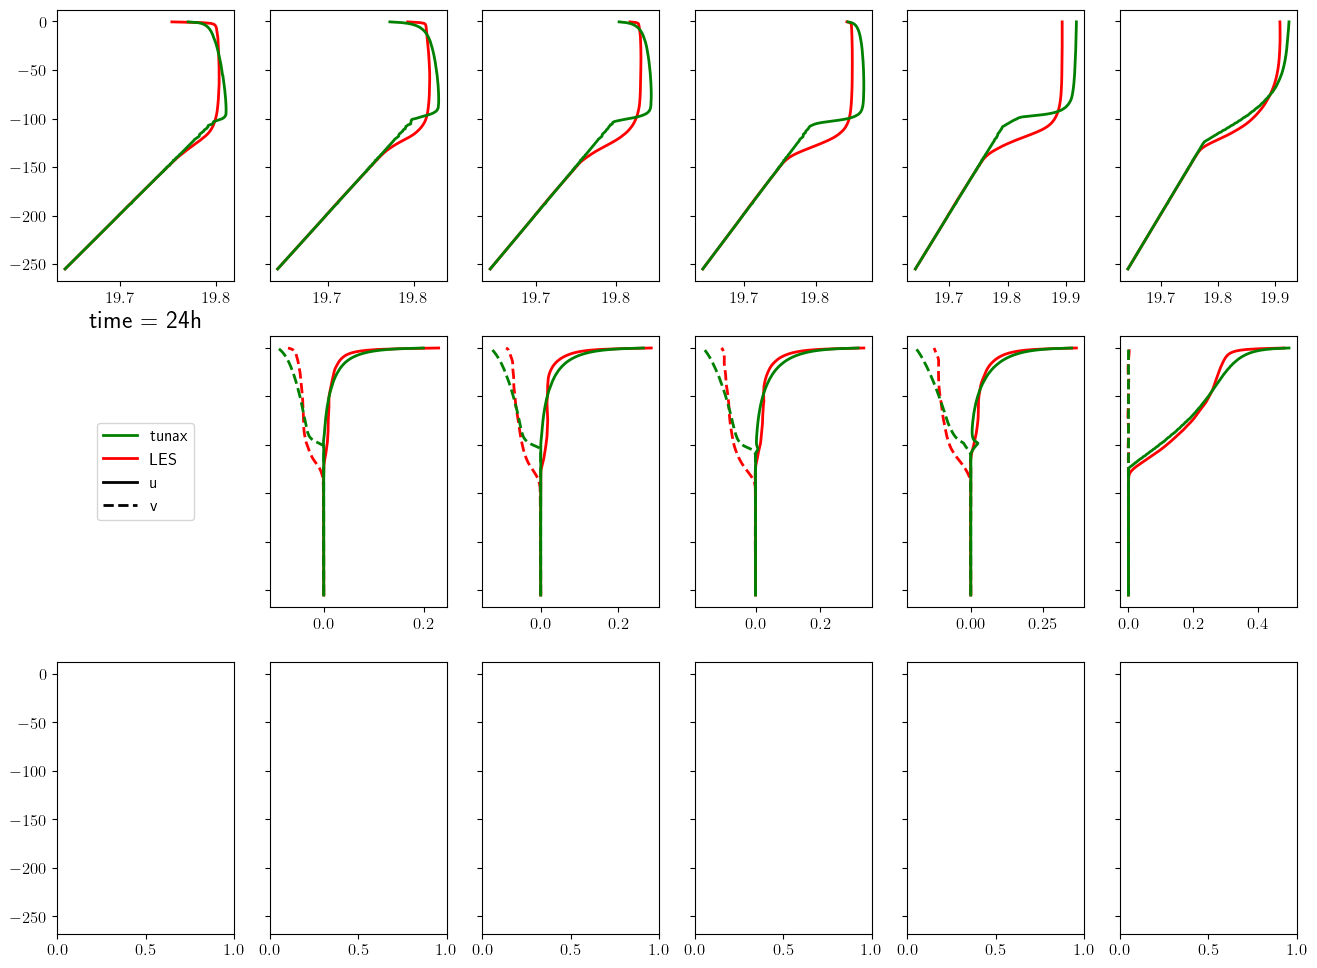

In [29]:
plot(24, 1)


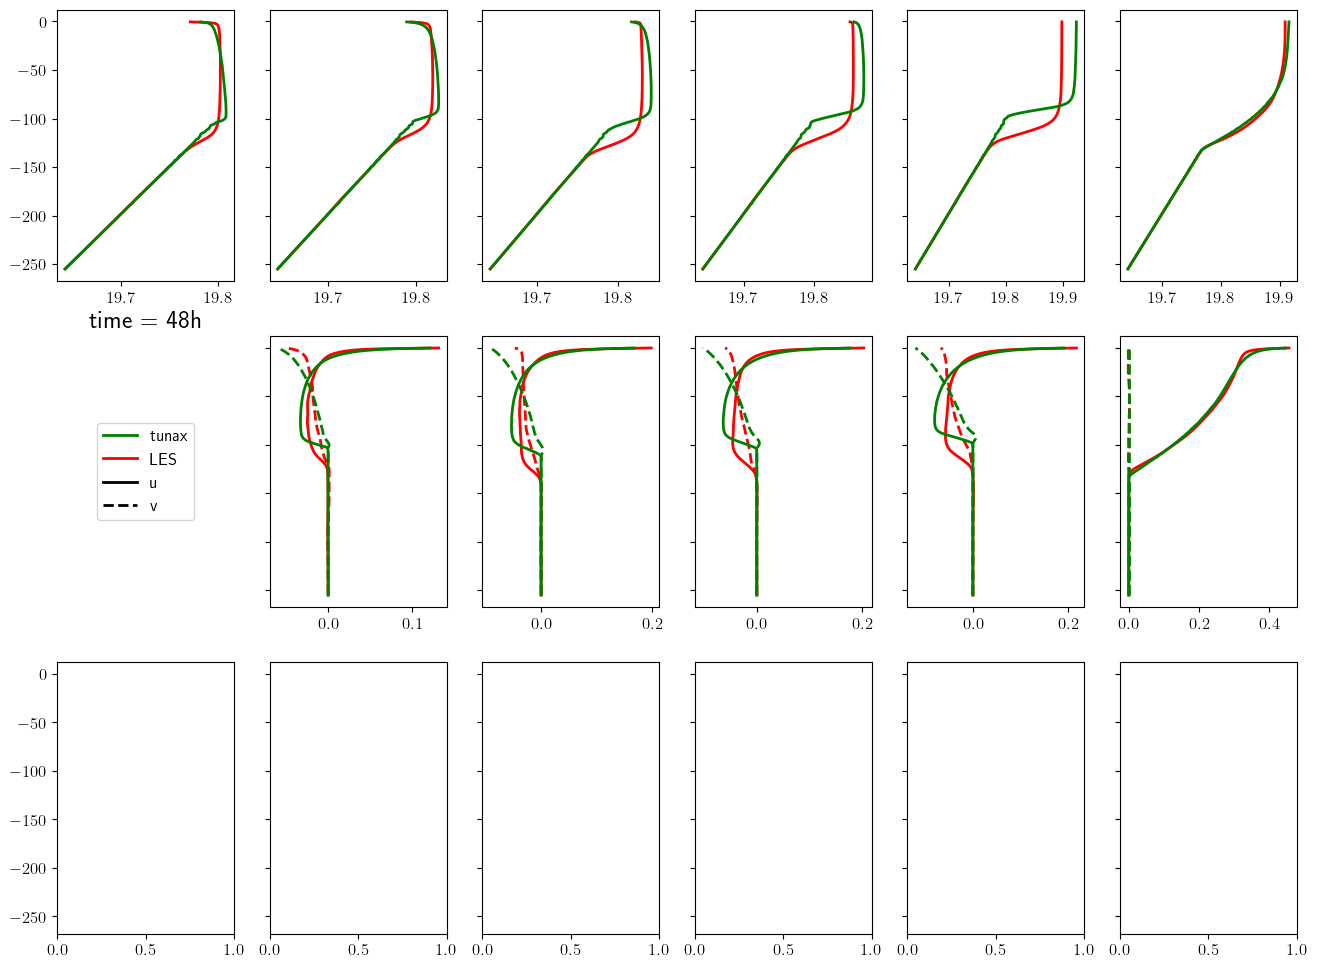

In [30]:
plot(48, 1)


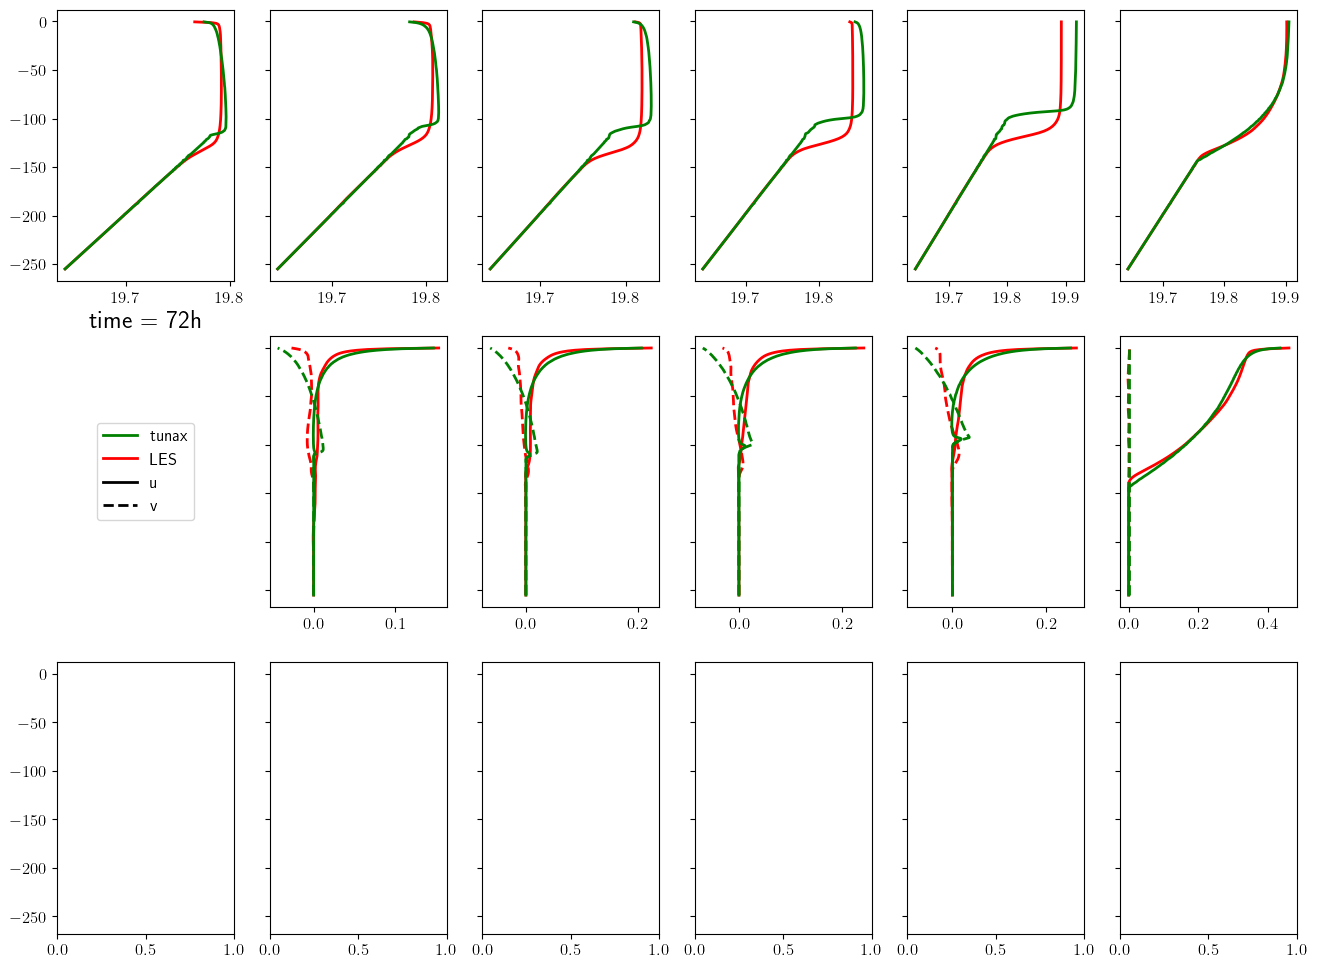

In [31]:
plot(72, 1)


In [3]:
from tunax import Grid
grid = Grid.linear(50, 50)
grid

from tunax import State
init_state = State.zeros(grid, ['t', 's', 'b', 'pt'])
init_state = init_state.init_t(hmxl=0., t_sfc=16.)
init_state = init_state.init_s(hmxl=100)
init_state

State(
  grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
  u=f32[50],
  v=f32[50],
  t=f32[50],
  s=f32[50],
  b=f32[50],
  pt=f32[50]
)

In [ ]:

from tunax import Case
import equinox as eqx
kp_case = Case(eos_tracers='b', do_pt=True)
kp_case = kp_case.set_dynamic_forcing_speed('u', 'sfc', 0.01)
kp_case

from tunax import SingleColumnModel
time_frame = 30.
dt = 30.
out_dt = 300.
model = SingleColumnModel(time_frame, dt, out_dt, init_state, kp_case, 'k-epsilon', 'pt')
model

from tunax.closures import KepsParameters
keps_default_params = KepsParameters()
keps_default_params

traj_obs = model.compute_trajectory_with(keps_default_params)
traj_obs

Trajectory(
  grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
  time=f32[360],
  u=f32[360,50],
  v=f32[360,50],
  t=None,
  s=None,
  b=f32[360,50],
  pt=None
)

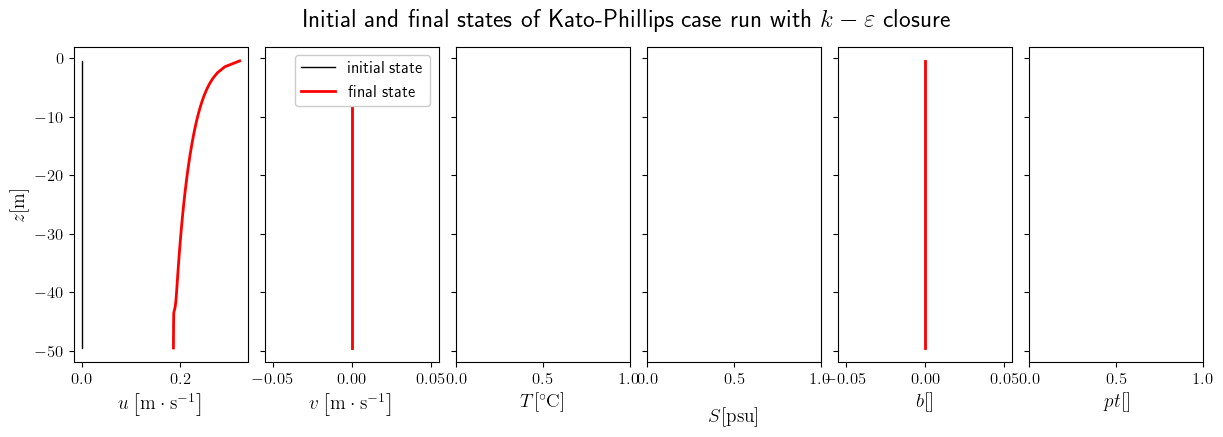

In [10]:
zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 6, sharey=True, figsize=(12, 4))
fig, [ax_u, ax_v, ax_t, ax_s, ax_b, ax_pt] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_u.plot(traj_obs.u[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_obs.u[-1, :], zr, 'r')
ax_v.plot(traj_obs.v[0, :], zr, 'k', linewidth=1, label='initial state')
ax_v.plot(traj_obs.v[-1, :], zr, 'r', label='final state')
if traj_obs.t is not None:
    ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
    ax_t.plot(traj_obs.t[-1, :], zr, 'r')
if traj_obs.s is not None:
    ax_s.plot(traj_obs.s[0, :], zr, 'k', linewidth=1)
    ax_s.plot(traj_obs.s[-1, :], zr, 'r')
if traj_obs.b is not None:
    ax_b.plot(traj_obs.b[0, :], zr, 'k', linewidth=1)
    ax_b.plot(traj_obs.b[-1, :], zr, 'r')
if traj_obs.pt is not None:
    ax_pt.plot(traj_obs.pt[0, :], zr, 'k', linewidth=1)
    ax_pt.plot(traj_obs.pt[-1, :], zr, 'r')

ax_u.set_xlabel(r'$u \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
ax_v.set_xlabel(r'$v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
ax_t.set_xlabel(r'$T [{}^\circ\mathrm C]$')
ax_s.set_xlabel(r'$S [\mathrm{psu}]$', labelpad=15)
ax_b.set_xlabel(r'$b []$')
ax_pt.set_xlabel(r'$pt []$')
ax_u.set_ylabel(r'$z [\mathrm m]$')
ax_v.legend(framealpha=1.)
fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')

plt.show()